# 0.0. Importações

## 0.1. Bibliotecas

In [27]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import inflection
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn import metrics as mt
from sklearn.ensemble      import RandomForestClassifier
import sweetviz as sv
import xgboost as xgb

## 0.3. Funções Auxiliares

In [43]:
def cross_val( X, y, model, cv, limiar = 0.5, verbose = True):

    scores = []

    for cv in np.arange(1,cv+1):

        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2 )

        model.fit(X_train, y_train)

        # Predictions
        probas = model.predict_proba(X_test)
        probas = probas.T[1]

        predictions = []

        for proba in probas:
            if proba > limiar:
                predictions.append(1)
            else:
                predictions.append(0)

        # Model evaluation
        score = mt.precision_score(y_test, predictions, average = 'micro')
        scores.append(score)

    if verbose == True:
        print('Score:',round(100*np.mean(scores),2))

    return np.mean(scores)



def rename_columns(dataframe):
    df = dataframe.copy()
    title = lambda x: inflection.titleize(x)
    snakecase = lambda x: inflection.underscore(x)
    accent = lambda x: inflection.transliterate(x)
    spaces = lambda x: x.replace(" ", "")
    cols_old = list(df.columns)
    cols_old = list(map(title, cols_old))
    cols_old = list(map(spaces, cols_old))
    cols_old = list(map(accent, cols_old))
    cols_new = list(map(snakecase, cols_old))
    df.columns = cols_new
    return df

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

## 0.2. Dados

In [3]:
df = pd.read_csv('../data/train.csv')

x = df.copy()
y = df['Satisfaction'].copy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

In [4]:
df.shape

(103904, 24)

In [5]:
df["Satisfaction"].value_counts(normalize = True)

Neutral or Dissatisfaction    0.566667
Satisfied                     0.433333
Name: Satisfaction, dtype: float64

In [6]:
x_train.shape

(83123, 24)

In [7]:
x_train["Satisfaction"].value_counts(normalize = True)

Neutral or Dissatisfaction    0.566666
Satisfied                     0.433334
Name: Satisfaction, dtype: float64

In [8]:
x_test.shape

(20781, 24)

In [9]:
x_test["Satisfaction"].value_counts(normalize = True)

Neutral or Dissatisfaction    0.566671
Satisfied                     0.433329
Name: Satisfaction, dtype: float64

# 1.0. Descrição dos dados

In [12]:
df1 = x_train.copy()

In [13]:
df1.head(15)

,id,Gender,Customer Type,Age,Type of Purchase,Store size,Store distance,InStore wifi,Open/Close time convenient,Easy of online shopping,...,Kids entertainment,Seller service,Showroom,Self-Store,Purchase service,Store Service,Cleanliness,Carrier delay in minutes,Delivery delay in minutes,Satisfaction
13845,75857,Female,Loyal Customer,30,Personal,Medium,1440,3,4,3,...,3,5,5,4,5,4,3,0,0.0,Neutral or Dissatisfaction
89846,87586,Male,Loyal Customer,61,Personal,Medium,432,1,1,1,...,5,1,1,3,3,4,5,45,40.0,Neutral or Dissatisfaction
32792,62893,Male,Loyal Customer,46,Gift,Large,3003,1,3,3,...,1,1,1,1,2,1,4,0,0.0,Neutral or Dissatisfaction
24758,79021,Male,Loyal Customer,45,Gift,Large,1612,1,1,4,...,5,5,5,5,4,5,5,0,0.0,Satisfied
70197,31575,Male,Loyal Customer,39,Gift,Large,602,5,5,4,...,4,4,4,4,4,4,3,0,0.0,Satisfied
21827,3933,Female,Loyal Customer,22,Gift,Large,3770,1,3,1,...,5,4,4,4,4,5,5,0,0.0,Satisfied
30391,66182,Male,Loyal Customer,22,Gift,Large,2883,3,3,3,...,5,4,3,4,4,4,5,22,21.0,Satisfied
86472,75207,Male,Loyal Customer,39,Gift,Large,1726,2,2,2,...,2,2,2,2,2,2,4,2,0.0,Neutral or Dissatisfaction
39862,117243,Female,Loyal Customer,27,Personal,Medium,325,3,4,3,...,1,3,4,2,5,5,1,70,92.0,Neutral or Dissatisfaction
81242,13093,Male,Loyal Customer,53,Gift,Large,595,5,5,4,...,5,5,4,5,4,5,4,18,13.0,Satisfied


## 1.1 Rename Columns 

In [14]:
df1.columns

Index(['id', 'Gender', 'Customer Type', 'Age', 'Type of Purchase',
       'Store size', 'Store distance', 'InStore wifi',
       'Open/Close time convenient', 'Easy of online shopping',
       'Store location', 'Toilet cleaning', 'Dressing room', 'Waiting room',
       'Kids entertainment', 'Seller service', 'Showroom ', 'Self-Store',
       'Purchase service', 'Store Service', 'Cleanliness',
       'Carrier delay in minutes', 'Delivery delay in minutes',
       'Satisfaction'],
      dtype='object')

In [15]:
df1 = rename_columns(df1)

In [16]:
df1.columns

Index(['id', 'gender', 'customer_type', 'age', 'type_of_purchase',
       'store_size', 'store_distance', 'in_store_wifi',
       'open/close_time_convenient', 'easy_of_online_shopping',
       'store_location', 'toilet_cleaning', 'dressing_room', 'waiting_room',
       'kids_entertainment', 'seller_service', 'showroom', 'self_store',
       'purchase_service', 'store_service', 'cleanliness',
       'carrier_delay_in_minutes', 'delivery_delay_in_minutes',
       'satisfaction'],
      dtype='object')

In [17]:
#renomeando nome das colunas para façam mais sentido durante análise, evitando interpretações erradas e levando em conta tamanho do nome


df1.rename(columns = {'open/close_time_convenient':'time_convenient', 'easy_of_online_shopping' : 'online_shopping', 'kids_entertainment': 'kids_entert',
                      'carrier_delay_in_minutes':'carrier_delay', 'delivery_delay_in_minutes' : 'delivery_delay'}, inplace = True)

In [18]:
df1.columns

Index(['id', 'gender', 'customer_type', 'age', 'type_of_purchase',
       'store_size', 'store_distance', 'in_store_wifi', 'time_convenient',
       'online_shopping', 'store_location', 'toilet_cleaning', 'dressing_room',
       'waiting_room', 'kids_entert', 'seller_service', 'showroom',
       'self_store', 'purchase_service', 'store_service', 'cleanliness',
       'carrier_delay', 'delivery_delay', 'satisfaction'],
      dtype='object')

## 1.1 Columns Meanings


- **id:** uma identificação única para cada cliente;


- **gender:** gênero do cliente;


- **customer_type:** Tipo de cliente (fidelizado ou não);
    

- **age:** idade do cliente;


- **type_of_purchase:** tipo de compras (pessoal ou presente);


- **store_size:** tamanho da loja;
    
    
- **store_distance:** distância da loja ao centro da cidade;


- **in_store_wifi:** nível de qualidade do wifi na loja (0 a 5);


- **time_convenient:** nível de sat. com horário de abertura e fechamento(0 a 5);


- **online_shopping:** nível de sat. com acesso ao shopping online(0 a 5);


- **store_location:** nível de sat. com a localização loja(0 a 5);
    
    
- **toilet_cleaning:** nível de sat. com a limpeza do banheiro da loja(0 a 5);


- **dressing_room:** nível de sat. com provador da loja(0 a 5);
    

- **waiting_room:** nível de sat. com sala de espera da loja(0 a 5);
    
    
- **kids_entert:** nível de sat. com área kid da loja(0 a 5);
    

- **seller_service:** nível de sat. com vendedores da loja(0 a 5);
    

- **showroom:** nível de sat. com showroom da loja(0 a 5);
    

- **self_store:** nível de sat. com histórico da loja(0 a 5);
    
    
- **purchase_service:** nível de sat. com a venda da loja(0 a 5);
    
    
- **store_service:** nível de sat. com atendimento da loja(0 a 5);
    
    
- **cleanliness:** nível de sat. com a limpeza da loja(0 a 5);
    
    
- **carrier_delay:** tempo de atraso da transportadora;
    
    
- **delivery_delay:** tempo de atraso da entrega;
    
    
- **satisfaction:** nível de satisfação (Satisfeito, neutro ou insatisfeito);

## 1.1. Dimensões

In [21]:
print("Este dataset tem {} linhas e {} colunas".format(df1.shape[0], df1.shape[1]))

Este dataset tem 83123 linhas e 24 colunas


## 1.2. Tipos

In [19]:
df1.dtypes

id                    int64
gender               object
customer_type        object
age                   int64
type_of_purchase     object
store_size           object
store_distance        int64
in_store_wifi         int64
time_convenient       int64
online_shopping       int64
store_location        int64
toilet_cleaning       int64
dressing_room         int64
waiting_room          int64
kids_entert           int64
seller_service        int64
showroom              int64
self_store            int64
purchase_service      int64
store_service         int64
cleanliness           int64
carrier_delay         int64
delivery_delay      float64
satisfaction         object
dtype: object

## 1.4. NaNs

In [20]:
df1.isna().sum()

id                    0
gender                0
customer_type         0
age                   0
type_of_purchase      0
store_size            0
store_distance        0
in_store_wifi         0
time_convenient       0
online_shopping       0
store_location        0
toilet_cleaning       0
dressing_room         0
waiting_room          0
kids_entert           0
seller_service        0
showroom              0
self_store            0
purchase_service      0
store_service         0
cleanliness           0
carrier_delay         0
delivery_delay      251
satisfaction          0
dtype: int64

In [21]:
## Substituir os NAN pela mediana dos valores da coluna
df1['delivery_delay'] = df1['delivery_delay'].fillna(df1['delivery_delay'].median())

In [22]:
df1.isna().sum()

id                  0
gender              0
customer_type       0
age                 0
type_of_purchase    0
store_size          0
store_distance      0
in_store_wifi       0
time_convenient     0
online_shopping     0
store_location      0
toilet_cleaning     0
dressing_room       0
waiting_room        0
kids_entert         0
seller_service      0
showroom            0
self_store          0
purchase_service    0
store_service       0
cleanliness         0
carrier_delay       0
delivery_delay      0
satisfaction        0
dtype: int64

## 1.5. Estatística Descritiva

In [23]:
var_num = df1.select_dtypes(include=['int64', 'float64'])
var_cat = df1.select_dtypes(exclude=['int64', 'float64'])

In [24]:
var_num.describe()

,id,age,store_distance,in_store_wifi,time_convenient,online_shopping,store_location,toilet_cleaning,dressing_room,waiting_room,kids_entert,seller_service,showroom,self_store,purchase_service,store_service,cleanliness,carrier_delay,delivery_delay
count,83123.000000,83123.000000,83123.000000,83123.000000,83123.000000,83123.000000,83123.000000,83123.000000,83123.000000,83123.000000,83123.000000,83123.000000,83123.000000,83123.000000,83123.000000,83123.000000,83123.000000,83123.000000,83123.000000
mean,64807.424708,39.379462,1191.352418,2.728030,3.061680,2.757083,2.977070,3.199945,3.251435,3.437665,3.358228,3.384984,3.351455,3.634710,3.305728,3.641627,3.285890,14.784404,15.081241
std,37469.108432,15.130789,997.846890,1.327402,1.524322,1.398202,1.276222,1.330807,1.348935,1.319070,1.333142,1.288058,1.315713,1.180139,1.265322,1.175149,1.313267,38.238149,38.630945
min,1.000000,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32416.500000,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,64646.000000,40.000000,844.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,97223.500000,51.000000,1744.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,129879.000000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


In [25]:
var_cat.describe(include='object')

,gender,customer_type,type_of_purchase,store_size,satisfaction
count,83123,83123,83123,83123,83123
unique,2,2,2,3,2
top,Female,Loyal Customer,Gift,Large,Neutral or Dissatisfaction
freq,42269,68022,57320,39769,47103


# 2.0. Feature Engineering

In [28]:
df2 = df1.copy()

In [41]:
#df2 = df2.loc[df2['age']>17,:]

# 3.0. Análise Exploratória de Dados

In [26]:
!pip install sweetviz

In [29]:
df3 = df2.copy()

## 3.0 Sweetviz

In [34]:
df3['satisfaction'] = df3['satisfaction'].apply(lambda x: 1 if x=='Satisfied' else 0)

In [35]:
# Analyse Dataset
report = sv.analyze(source = df3, target_feat = 'satisfaction')

                                             |          | [  0%]   00:00 -> (? left)

In [36]:
report.show_html()

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## 3.1. Univariada

### 3.1.1. Variável Alvo

C:\Users\ander\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='satisfaction', ylabel='count'>

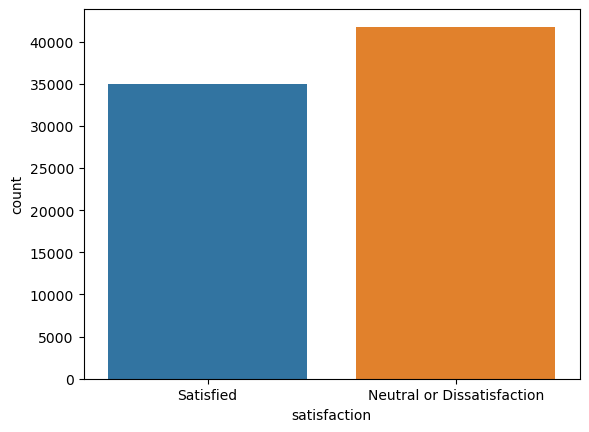

In [43]:
sns.countplot(df3['satisfaction'])

### 3.1.2. Variáveis Numéricas

In [ ]:
var_num = df3.select_dtypes(include=['int64', 'float64'])

In [ ]:
for c in var_num.columns:
    px.box(df3,y=c).show()

### 3.1.3. Variáveis Categóricas

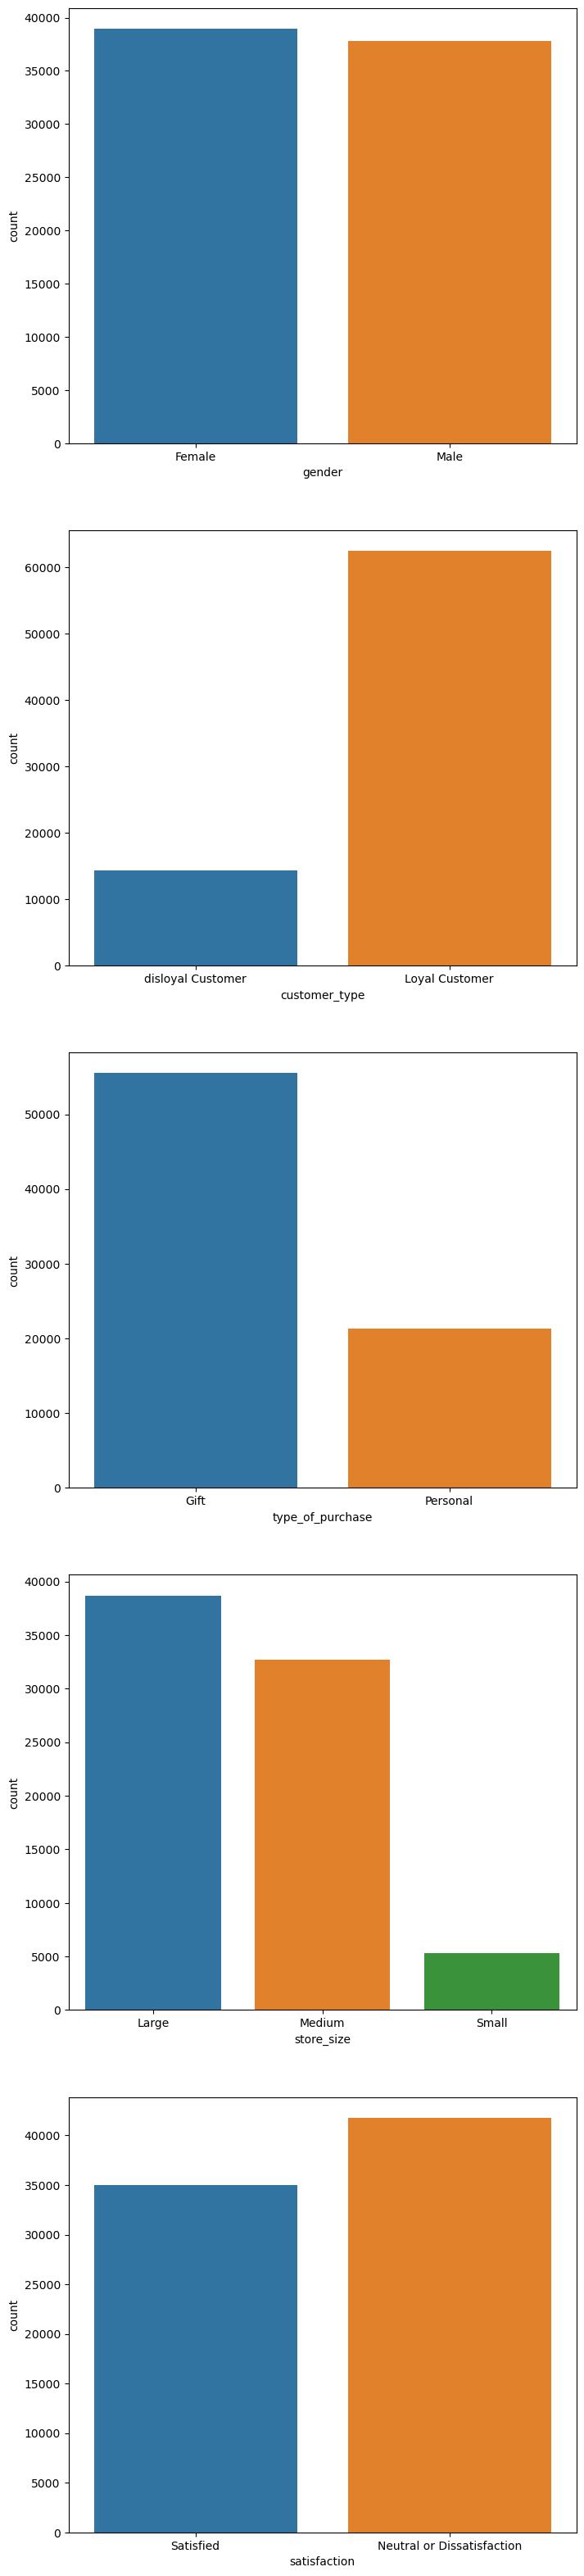

In [49]:
num_countplots = len(var_cat.columns)

fig, axes = plt.subplots(nrows=num_countplots, ncols=1, figsize=(8, 40))

for i, ax in enumerate(axes):
    c = var_cat.columns[i]
    sns.countplot(data=df3, x=c, ax=ax)

## 3.2. Bivariada

### 3.2.1. Variáveis Numéricas

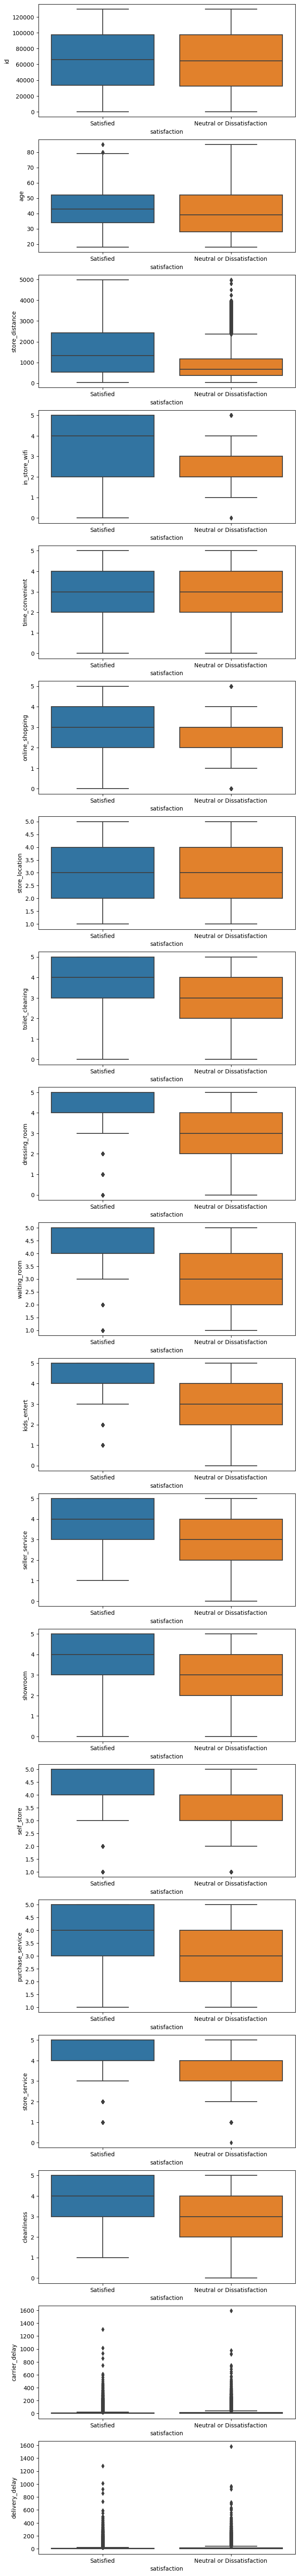

In [53]:
num_boxplots = len(var_num.columns)

fig, axes = plt.subplots(nrows=num_boxplots, ncols=1, figsize=(8, 80))

for i, ax in enumerate(axes):
    c = var_num.columns[i]
    sns.boxplot(x='satisfaction', y=c, data=df3, ax=ax)

### 3.2.2. Variáveis Categóricas

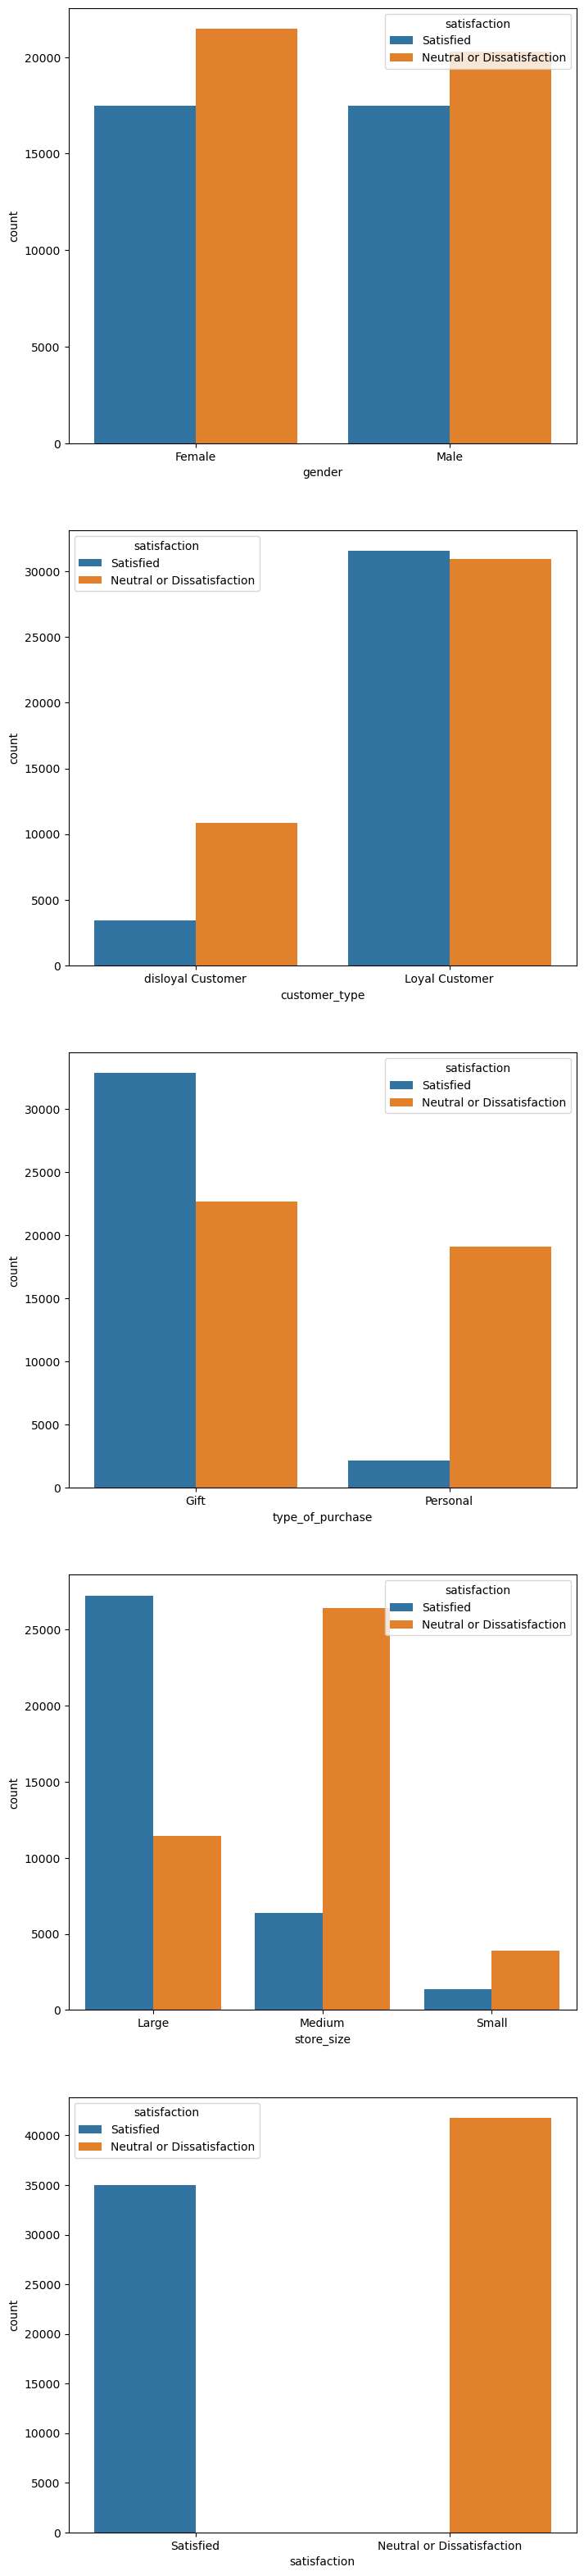

In [56]:
num_countplots = len(var_cat.columns)

fig, axes = plt.subplots(nrows=num_countplots, ncols=1, figsize=(8, 40))

for i, ax in enumerate(axes):
    c = var_cat.columns[i]
    sns.countplot(data=df3, x=c, ax=ax, hue='satisfaction')

## 3.3. Multivariada

### 3.3.1. Variávei Numéricas

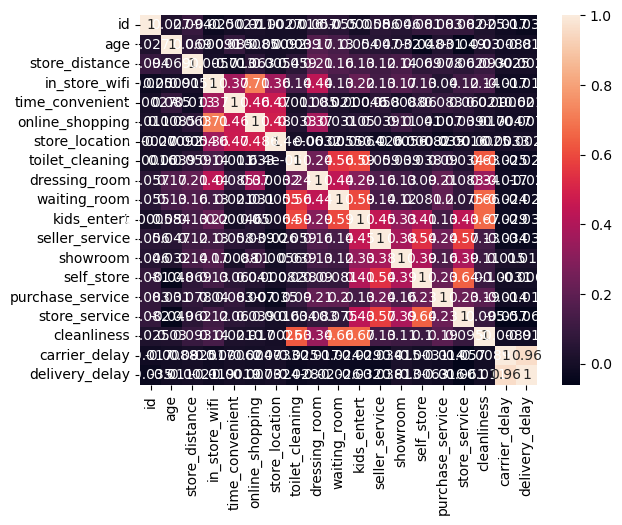

In [57]:
correlation = var_num.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 3.3.2. Variáveis Categóricas

<AxesSubplot:>

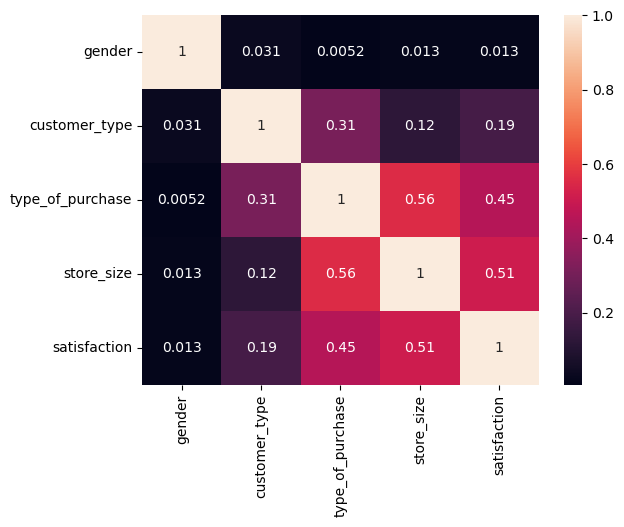

In [61]:
corr_matrix = pd.DataFrame(index=var_cat.columns, columns=var_cat.columns)

for i in range(len(var_cat.columns)):
    for j in range(len(var_cat.columns)):
        corr_matrix.iloc[i,j] = cramers_v(var_cat.iloc[:,i], var_cat.iloc[:,j])

corr_matrix = corr_matrix.astype(float)

sns.heatmap(corr_matrix, annot=True)

# 4.0. Preparação dos Dados

In [37]:
df4 = df3.copy()

## 4.1. Filtragem

## 4.2. Encoding

In [62]:
var_cat.nunique()

gender              2
customer_type       2
type_of_purchase    2
store_size          3
satisfaction        2
dtype: int64

In [68]:
var_cat['satisfaction'].unique()

array(['Satisfied', 'Neutral or Dissatisfaction'], dtype=object)

In [38]:
df4['gender'] = df4['gender'].apply(lambda x: 1 if x=='Female' else 0)
df4['customer_type'] = df4['customer_type'].apply(lambda x: 1 if x=='Loyal Customer' else 0)
df4['type_of_purchase'] = df4['type_of_purchase'].apply(lambda x: 1 if x=='Personal' else 0)
df4 = pd.get_dummies(df4, prefix='Size', columns=['store_size'])

## 4.3. Rescaling

In [39]:
mms = MinMaxScaler()
for c in var_num.columns:
    if c in df4:
        df4[c] = mms.fit_transform(df4[[c]].values)

# 5.0. Feature Selection

In [40]:
df5 = df4.copy()

# 6.0. Modelos de Machine Learning

In [41]:
df6 = df5.copy()

In [42]:
x = df6.drop(columns='satisfaction')
y = df6['satisfaction']

## 6.1. XGBoost

In [83]:
xgb_model = xgb.XGBClassifier(n_estimators = 2500)
cross_val(x, y, xgb_model, 1, limiar = 0.5, verbose = True)

Score: 95.69


0.9569170816193981

## 6.2. Random Forest

In [84]:
rf_model = RandomForestClassifier(n_estimators = 2500)
cross_val(x, y, rf_model, 1, limiar = 0.5, verbose = True)

Score: 96.0


0.9600115698893629

# 7.0. Hiperparâmetros

In [ ]:
df7 = df6.copy()

# 8.0. Interpretação do Erro

In [ ]:
df8 = df7.copy()

# 9.0. Submissão

In [99]:
dados = pd.read_csv('test.csv')

In [100]:
Y_test = pd.DataFrame()
Y_test['id'] = dados['id']

In [101]:
dados.isna().sum()

id                             0
Gender                         0
Customer Type                  0
Age                            0
Type of Purchase               0
Store size                     0
Store distance                 0
InStore wifi                   0
Open/Close time convenient     0
Easy of online shopping        0
Store location                 0
Toilet cleaning                0
Dressing room                  0
Waiting room                   0
Kids entertainment             0
Seller service                 0
Showroom                       0
Self-Store                     0
Purchase service               0
Store Service                  0
Cleanliness                    0
Carrier delay in minutes       0
Delivery delay in minutes     83
dtype: int64

In [102]:
dados['Delivery delay in minutes'] = dados['Delivery delay in minutes'].fillna(dados['Delivery delay in minutes'].median())

In [103]:
dados = rename_columns(dados)

In [104]:
dados.rename(columns = {'open/close_time_convenient':'time_convenient', 'easy_of_online_shopping' : 'online_shopping', 'kids_entertainment': 'kids_entert',
                      'carrier_delay_in_minutes':'carrier_delay', 'delivery_delay_in_minutes' : 'delivery_delay'}, inplace = True)

In [105]:
dados['gender'] = dados['gender'].apply(lambda x: 1 if x=='Female' else 0)
dados['customer_type'] = dados['customer_type'].apply(lambda x: 1 if x=='Loyal Customer' else 0)
dados['type_of_purchase'] = dados['type_of_purchase'].apply(lambda x: 1 if x=='Personal' else 0)
dados = pd.get_dummies(dados, prefix='Size', columns=['store_size'])

In [106]:
mms = MinMaxScaler()
for c in var_num.columns:
    if c in dados:
        dados[c] = mms.fit_transform(dados[[c]].values)

In [107]:
dados.columns

Index(['id', 'gender', 'customer_type', 'age', 'type_of_purchase',
       'store_distance', 'in_store_wifi', 'time_convenient', 'online_shopping',
       'store_location', 'toilet_cleaning', 'dressing_room', 'waiting_room',
       'kids_entert', 'seller_service', 'showroom', 'self_store',
       'purchase_service', 'store_service', 'cleanliness', 'carrier_delay',
       'delivery_delay', 'Size_Large', 'Size_Medium', 'Size_Small'],
      dtype='object')

In [108]:
Y_test['satisfaction'] = rf_model.predict(dados)